# This notebook merges data from OGLE II and III (from Bird+2012) with data from OGLE IV

In [1]:
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import pandas as pd
import re
import glob

data_dir = "../data/"
list_from_bird_dir = "../data/ogle2_and_3/xrom_fixed/list.txt"

In [3]:
import psutil
psutil.Process().nice(5)# if on *ux

# check coverage of the data 

In [5]:
# load the list of SPX names from Bird+2012 and their corresponding IDs

with open(list_from_bird_dir) as f:
    lines = f.readlines()

ids_names = [re.split("\s+", line)[:3] for line in lines]
ids_names = [x[1:] if (x[0] == '') else x for x in ids_names]
ids_names = [x[:2] if len(x)>2 else x for x in ids_names]
ids_names = [x for x in ids_names if len(x)>1]
ids_names_bird = {int(sxp_id): sxp_name.lower() for sxp_id,sxp_name in ids_names}

In [119]:
# check the dates that the different data sets span for each source

# data_sets = ["ogle2_3/xrom_fixed/phot_I_calib/", "ogle3/", "ogle4/"]


ogle2_3_start_end = {}
ogle3_start_end = {}
ogle4_start_end = {}
maxima_2_3 = {}
maxima_3 = {}

for source_index, source_name in ids_names_bird.items():
    source_data = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/{}.dat'.format(source_index))
    ogle2_3_start_end[source_name] = (source_data[0,0], source_data[-1,0])
    try:
        maxima_2_3[source_name] = source_data[:,0][-740:][np.argmin(source_data[:,1])]
    except:
        maxima_2_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]

    
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle3/{}/phot.dat'.format(source_name))
        ogle3_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
        maxima_3[source_name] = source_data[:,0][np.argmin(source_data[:,1])]-2450000
    except:
        print("{} not found in OGLE3".format(source_name))
        ogle3_start_end[source_name] = (np.nan, np.nan)
        maxima_3[source_name] = np.nan

        
for source_index, source_name in ids_names_bird.items():
    try:
        source_data = np.loadtxt('../data/ogle4/{}/phot.dat'.format(source_name))
        ogle4_start_end[source_name] = (source_data[0,0]-2450000, source_data[-1,0]-2450000)
    except:
        print("{} not found in OGLE4".format(source_name))
        ogle4_start_end[source_name] = (np.nan, np.nan)

ogle_dates = pd.DataFrame({"ogle2_3_start":[ogle2_3_start_end[x][0] for x in ids_names_bird.values()],
                           "ogle2_3_end":[ogle2_3_start_end[x][1] for x in ids_names_bird.values()], 
                           "ogle3_start":[ogle3_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle3_end":[ogle3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "ogle3_start_diff":[ogle3_start_end[x][0]-ogle2_3_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle3_end_diff":[ogle3_start_end[x][1]-ogle2_3_start_end[x][1] for x in ids_names_bird.values()],
                           
                           "ogle4_start":[ogle4_start_end[x][0] for x in ids_names_bird.values()], 
                           "ogle4_end":[ogle4_start_end[x][1] for x in ids_names_bird.values()],
                          "maximum2_3":[maxima_2_3[x] for x in ids_names_bird.values()],
                          "maximum3":[maxima_3[x] for x in ids_names_bird.values()]},
                          index=ids_names_bird.values())

ogle_dates = ogle_dates[["ogle2_3_start", "ogle2_3_end", "ogle3_start", "ogle3_end","ogle3_start_diff","ogle3_end_diff", "maximum2_3", "maximum3", "ogle4_start", "ogle4_end"]]

sxp3.34 not found in OGLE3
sxp6.85 not found in OGLE3
sxp6.88 not found in OGLE3
sxp11.5 not found in OGLE3
sxp65.8 not found in OGLE3
sxp348 not found in OGLE3
rx-j0516.0-6916 not found in OGLE4
xmmu-j054134.7-682550 not found in OGLE4
rx-j0544.1-7100 not found in OGLE4
sxp2.763 not found in OGLE4
sxp18.3 not found in OGLE4
sxp31.0 not found in OGLE4
sxp152.1 not found in OGLE4
sxp202b not found in OGLE4
sxp264 not found in OGLE4
sxp455a not found in OGLE4
sxp455b not found in OGLE4
sxp893 not found in OGLE4
ma93-798 not found in OGLE4


In [120]:
start_short = []
finish_short = []

tolerance_days=0.01

for name, source in ogle_dates.iterrows():
    if source.ogle2_3_start-tolerance_days > source.ogle3_start:
        start_short.append(name)
        print(source.name, "Tony's data starts too late")
    if source.ogle2_3_end+tolerance_days < source.ogle3_end:
        finish_short.append(name)
        print(source.name, "Tony's data ends too early")

ogle_dates.style.apply(lambda x: ['background: lightgreen' 
                                  if (x.name in start_short)
                                  else 'background: yellow'
                                  if (x.name in finish_short)
                                  else '' for i in x], axis=1)

xmmu-j054134.7-682550 Tony's data starts too late
xmmu-j054134.7-682550 Tony's data ends too early
cal-83 Tony's data starts too late
sxp0.92 Tony's data ends too early
sxp9.13 Tony's data ends too early
sxp34.08 Tony's data ends too early
sxp46.6 Tony's data ends too early
sxp152.1 Tony's data ends too early
sxp169.3 Tony's data ends too early
sxp202b Tony's data ends too early
sxp304 Tony's data ends too early
sxp323 Tony's data ends too early
sxp342 Tony's data ends too early
sxp504 Tony's data ends too early
sxp565 Tony's data ends too early
sxp726 Tony's data ends too early
sxp1323 Tony's data ends too early
ma93-798 Tony's data ends too early
ogle-smc-sc5-180008 Tony's data ends too early
sxp0.09 Tony's data ends too early


,ogle2_3_start,ogle2_3_end,ogle3_start,ogle3_end,ogle3_start_diff,ogle3_end_diff,maximum2_3,maximum3,ogle4_start,ogle4_end
rx-j0513.9-6951,2167.85,4951.52,2167.85,4951.52,-2.14186e-10,6.18456e-11,2605.75,2605.75,5260.61,8921.57
rx-j0516.0-6916,457.65,4953.52,2112.93,4953.52,1655.28,-1.33696e-10,922.48,3058.59,nan,nan
rx-j0520.5-6932,455.675,4953.52,2112.93,4953.52,1657.26,-1.33696e-10,2968.65,2135.92,5260.61,8921.57
xmmu-j054134.7-682550,2187.3,4947.03,2168.85,4947.53,-18.4464,0.50151,3747.34,4348.88,nan,nan
cal-83,2187.8,4947.53,2168.85,4947.53,-18.9418,1.17325e-10,3088.59,3088.59,5261.66,8921.59
rx-j0544.1-7100,2168.87,4933.59,2168.87,4933.59,-1.40062e-10,1.76442e-10,4378.78,4378.78,nan,nan
sxp0.92,625.43,4866.05,2090.91,4866.55,1465.48,0.50206,1872.06,2222.63,5346.92,8869.58
sxp2.37,2086.93,4868.56,2086.93,4868.56,6.82121e-12,-5.54792e-11,4475.55,4475.55,5346.92,8759.65
sxp2.763,2086.93,4868.57,2086.93,4868.57,-1.3415e-10,-2.29193e-10,3020.6,2850.92,nan,nan
sxp7.78,2086.89,4952.92,2086.89,4952.92,-2.50111e-11,-6.00267e-11,2521.83,2472.92,5346.92,8869.57


In [115]:
ogle_dates.index.values

array(['rx-j0513.9-6951', 'rx-j0516.0-6916', 'rx-j0520.5-6932',
       'xmmu-j054134.7-682550', 'cal-83', 'rx-j0544.1-7100', 'sxp0.92',
       'sxp2.37', 'sxp2.763', 'sxp7.78', 'sxp8.80', 'sxp9.13', 'sxp15.3',
       'sxp18.3', 'sxp22.07', 'sxp25.5', 'sxp31.0', 'sxp34.08', 'sxp46.6',
       'sxp59.0', 'sxp74.7', 'sxp82.4', 'sxp91.1', 'sxp101', 'sxp138',
       'sxp140', 'sxp152.1', 'sxp169.3', 'sxp172', 'sxp202', 'sxp202b',
       'sxp264', 'sxp280.4', 'sxp293', 'sxp304', 'sxp323', 'sxp327',
       'sxp342', 'sxp455a', 'sxp455b', 'sxp504', 'sxp565', 'sxp645',
       'sxp701', 'sxp726', 'sxp756', 'sxp893', 'sxp967', 'sxp1323',
       'rx-j0052.1-7319', 'ma93-798', 'ogle-smc-sc5-180008', 'sxp0.09',
       'sxp7.92', 'sxp3.34', 'sxp6.85', 'sxp6.88', 'sxp11.5', 'sxp65.8',
       'sxp348'], dtype=object)

# view the data for a few sources

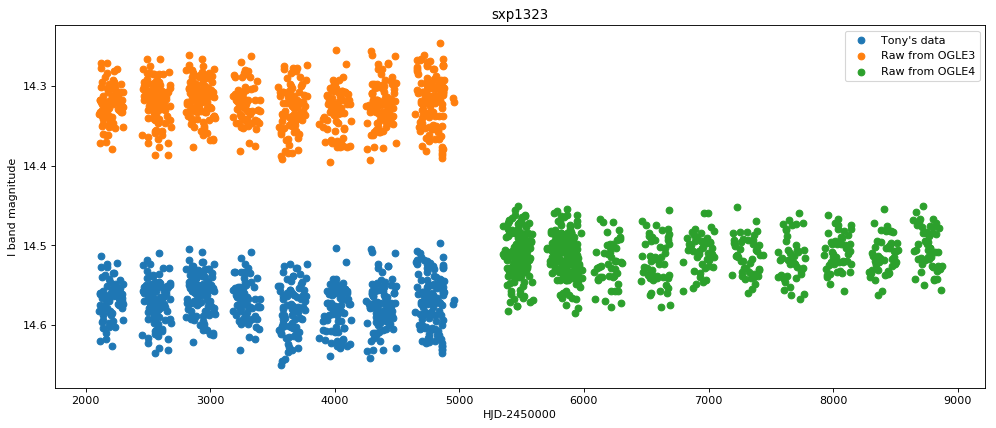

In [103]:
lc_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/49.dat')
lc_ogle3 = np.loadtxt('../data/ogle3/sxp1323/phot.dat')
lc_ogle4 = np.loadtxt('../data/ogle4/sxp1323/phot.dat')


plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(lc_bird[-724:,0], lc_bird[-724:,1], label="Tony's data")
plt.scatter(lc_ogle3[:,0]-2450000, lc_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(lc_ogle4[:,0]-2450000, lc_ogle4[:,1], label="Raw from OGLE4")
plt.title("sxp1323")
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [98]:
lc_bird[-724:,0][0]

2104.38

In [99]:
(lc_ogle3[:,0]-2450000)[0]

2104.880150000099

In [77]:
print(lc_bird[:,0][np.argmin(lc_bird[:,1])])
print(lc_ogle3[:,0][np.argmin(lc_ogle3[:,1])]-2450000)


4844.1
4844.60112999985


In [88]:
(lc_ogle3[:,0]-2450000) - lc_bird[-731:,0]

array([283.66015, 289.6305 , 286.67654, 286.63441, 253.6528 , 257.62443,
       250.66839,  20.55287,  15.48598,  13.47832,  14.39712,  14.43013,
        10.49489,  10.48739,  10.4305 ,   7.51742,   6.58121,   7.42971,
         8.51393,   8.40415,   8.51404,   8.4831 ,   8.39872,  16.36451,
        19.53374,  20.44406,  23.42491,  23.43814,  12.54273,  12.50103,
        11.44706,   8.44079,  10.44892,  15.48804,  12.45021,  12.4537 ,
        12.49851,  10.46851,   5.49013,   4.50023,   4.48436,   3.46825,
         3.49545,   3.56029,   8.50467,  10.36292,  12.45263,   8.48672,
         8.60464,   6.54125,   6.49127,   4.52725,   5.49642,   5.5334 ,
         7.5427 ,   6.48776,   8.31608,   6.33369,   7.36177,   4.45478,
         4.5568 ,   4.53602,   5.43357,   5.48835,   4.5867 ,   8.49288,
         8.50684,   5.51061,   5.46795,   5.53878,   6.52526,   5.4932 ,
         4.48713,   7.48206,   7.47129,   5.49597,   7.48988,   9.48584,
         9.53168,   6.53693,   4.50336,   4.49006, 

In [87]:
lc_bird[-731:,0]

array([1821.22, 1823.29, 1829.22, 1830.29, 1864.23, 1865.24, 1873.21,
       2104.38, 2112.42, 2115.4 , 2116.42, 2117.38, 2122.36, 2123.38,
       2124.43, 2128.38, 2130.32, 2131.31, 2132.35, 2133.37, 2134.36,
       2135.4 , 2136.4 , 2140.36, 2141.27, 2142.37, 2143.38, 2144.3 ,
       2156.22, 2160.3 , 2162.31, 2166.3 , 2167.24, 2168.26, 2172.3 ,
       2173.26, 2174.24, 2177.19, 2184.25, 2186.24, 2187.16, 2189.24,
       2190.24, 2191.14, 2192.21, 2193.24, 2194.2 , 2200.21, 2203.1 ,
       2206.15, 2208.2 , 2211.2 , 2212.19, 2214.19, 2215.23, 2217.19,
       2219.22, 2222.27, 2223.18, 2228.1 , 2230.04, 2232.05, 2234.1 ,
       2236.09, 2239.03, 2241.08, 2243.12, 2249.07, 2251.13, 2254.08,
       2256.1 , 2259.12, 2262.13, 2264.11, 2266.12, 2271.09, 2273.09,
       2276.09, 2280.08, 2285.08, 2289.11, 2291.12, 2293.11, 2295.11,
       2297.11, 2299.11, 2301.1 , 2453.39, 2460.43, 2464.39, 2466.39,
       2468.38, 2470.37, 2472.39, 2481.38, 2483.44, 2486.44, 2489.32,
       2490.32, 2496

In [54]:
lc_bird[-1,0]

4951.52447

In [53]:
ogle_dates.loc["rx-j0513.9-6951"]

ogle2_3_start    2086.43000
ogle2_3_end      4954.43000
ogle3_start      2086.92886
ogle3_end        4954.92531
ogle4_start      5346.91893
ogle4_end        8869.57316
Name: rx-j0513.9-6951, dtype: float64

In [55]:
source_data = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/1.dat'.format(source_index))

In [58]:
source_data[-1][0]

4951.52447

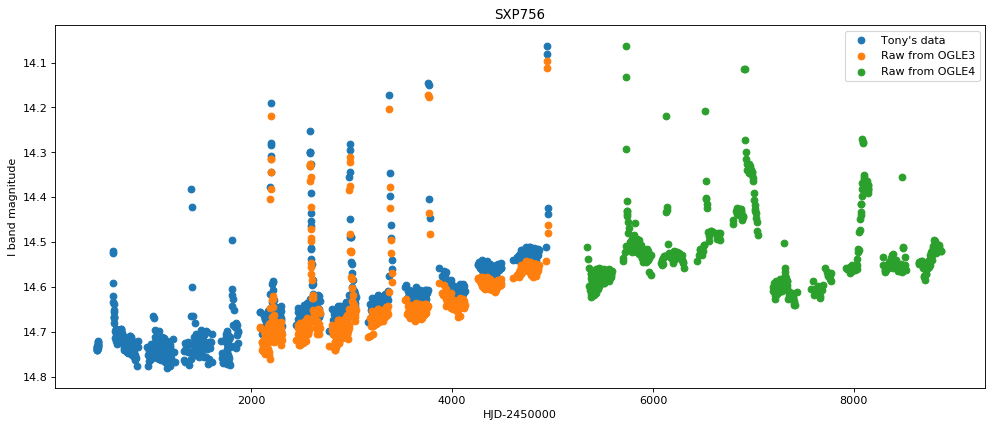

In [18]:
sxp304_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/46.dat')
sxp304_ogle3 = np.loadtxt('../data/ogle3/sxp756/phot.dat')
sxp304_ogle4 = np.loadtxt('../data/ogle4/sxp756/phot.dat')


plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(sxp304_bird[:,0], sxp304_bird[:,1], label="Tony's data")
plt.scatter(sxp304_ogle3[:,0]-2450000, sxp304_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(sxp304_ogle4[:,0]-2450000, sxp304_ogle4[:,1], label="Raw from OGLE4")
plt.title("SXP756")
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

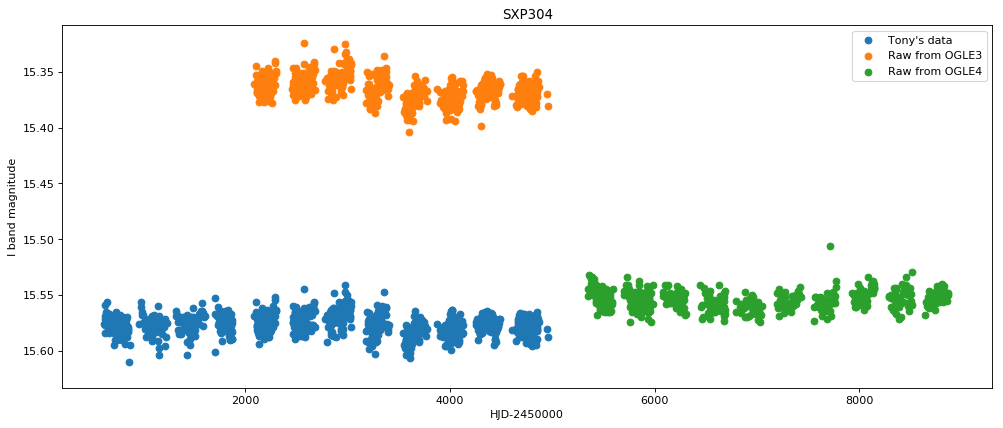

In [11]:
sxp304_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/35.dat')
sxp304_ogle3 = np.loadtxt('../data/ogle3/sxp304/phot.dat')
sxp304_ogle4 = np.loadtxt('../data/ogle4/sxp304/phot.dat')


plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(sxp304_bird[:,0], sxp304_bird[:,1], label="Tony's data")
plt.scatter(sxp304_ogle3[:,0]-2450000, sxp304_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(sxp304_ogle4[:,0]-2450000, sxp304_ogle4[:,1], label="Raw from OGLE4")
plt.title("SXP304")
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

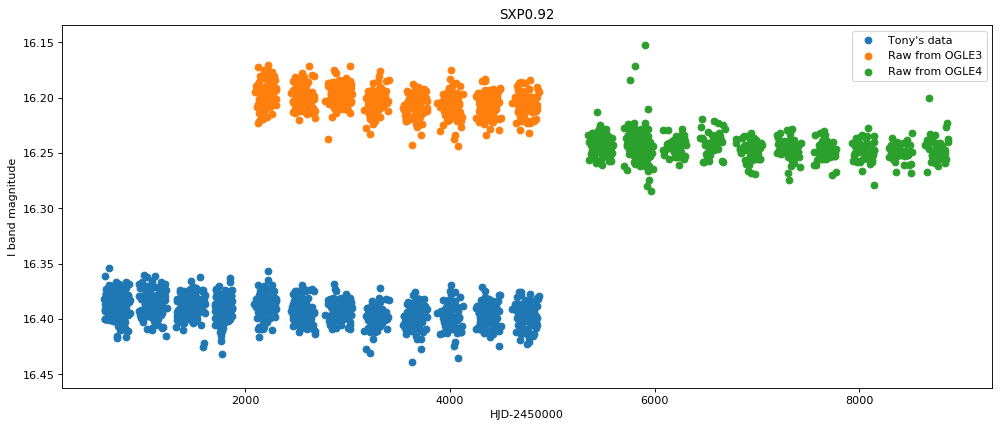

In [12]:
sxp304_bird = np.loadtxt('../data/ogle2_and_3/xrom_fixed/phot_I_calib/7.dat')
sxp304_ogle3 = np.loadtxt('../data/ogle3/sxp0.92/phot.dat')
sxp304_ogle4 = np.loadtxt('../data/ogle4/sxp0.92/phot.dat')


plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(sxp304_bird[:,0], sxp304_bird[:,1], label="Tony's data")
plt.scatter(sxp304_ogle3[:,0]-2450000, sxp304_ogle3[:,1], label="Raw from OGLE3")
plt.scatter(sxp304_ogle4[:,0]-2450000, sxp304_ogle4[:,1], label="Raw from OGLE4")
plt.title("SXP0.92")
plt.xlabel("HJD-2450000")
plt.ylabel("I band magnitude")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# find the coverage of the different data sets

,ogle2_3_start,ogle2_3_end,ogle3_start,ogle3_end,ogle4_start,ogle4_end
rx-j0513.9-6951,2086.43,4954.43,2086.93,4954.93,5346.92,8869.57
rx-j0516.0-6916,2086.89,4952.92,2086.89,4952.92,5346.92,8869.57
rx-j0520.5-6932,621.857,4954.93,2086.93,4954.93,5346.92,8759.65
xmmu-j054134.7-682550,621.801,4954.89,2085.91,4954.89,5346.92,8869.58
cal-83,455.675,4953.52,2112.93,4953.52,5260.61,8921.57
rx-j0544.1-7100,466.577,4952.92,2086.89,4952.92,5346.92,8869.57
sxp0.92,466.545,4952.92,2086.89,4952.92,nan,nan
sxp2.37,457.65,4953.52,2112.93,4953.52,nan,nan
sxp2.763,2187.3,4947.03,2168.85,4947.53,nan,nan
sxp7.78,466.55,4954.89,2085.91,4954.89,5346.92,8869.58


In [95]:
ogle2_3_start_end

{'rx-j0513.9-6951': (2167.84574, 4951.52447),
 'rx-j0516.0-6916': (457.65019, 4953.5168),
 'rx-j0520.5-6932': (455.67483, 4953.5168),
 'xmmu-j054134.7-682550': (2187.3, 4947.03),
 'cal-83': (2187.79538, 4947.53151),
 'rx-j0544.1-7100': (2168.86801, 4933.58937),
 'sxp0.92': (625.43, 4866.05),
 'sxp2.37': (2086.92527, 4868.56023),
 'sxp2.763': (2086.93259, 4868.56724),
 'sxp7.78': (2086.89212, 4952.92202),
 'sxp8.80': (466.60781, 4952.92202),
 'sxp9.13': (466.043, 4954.39),
 'sxp15.3': (466.55712, 4954.88836),
 'sxp18.3': (466.5448, 4952.92202),
 'sxp22.07': (2104.8951, 4873.5558),
 'sxp25.5': (621.8006, 4954.88836),
 'sxp31.0': (2104.8951, 4873.5558),
 'sxp34.08': (2086.43, 4954.43),
 'sxp46.6': (2086.39, 4954.43),
 'sxp59.0': (626.93294, 4954.92531),
 'sxp74.7': (466.54467, 4954.88836),
 'sxp82.4': (466.57656, 4952.92202),
 'sxp91.1': (2086.89595, 4865.55783),
 'sxp101': (2086.92153, 4954.9177),
 'sxp138': (2086.89212, 4952.92202),
 'sxp140': (2086.92886, 4954.92531),
 'sxp152.1': (208

In [73]:
glob.glob(os.path.join(data_set_dir+"1*"))

[]

In [74]:
glob.glob("/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/1*")

['/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/1.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/18.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/15.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/11.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/10.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/14.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/19.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/16.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/13.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/12.dat',
 '/data/jkok1g14/ogle_xrom/period_search/data/ogle2_and_3/xrom_fixed/phot_I_calib/17.dat']

In [72]:
os.path.join(data_set_dir+"1.dat")

'../data/ogle2_3/xrom_fixed/phot_I_calib/1.dat'

In [ ]:
# Photometry data files contain 5 columns: Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

# save data as csv, merging OGLE III and IV if both are available
sources={}
dir_list = []

# search for photometry data in OGLE IV folder
for root, dirnames, filenames in os.walk(data_path+"/ogle4"):
    for filename in fnmatch.filter(filenames, "phot.dat"):
        source_name = root.split("/")[-1]
        lc_path_4 = os.path.join(root, filename)
        lc_path_3 = os.path.join(root.replace("ogle4", "ogle3"), filename)
        try: # try to merge OGLE III and IV data
            ogle3 = np.loadtxt(lc_path_3, usecols=(0,1,2))
            ogle4 = np.loadtxt(lc_path_4, usecols=(0,1,2))
            data = np.vstack((ogle3, ogle4))
            sources[root.split("/")[-1]] = "{} measurements, start: {} end: {}".format(len(data), data[0][0]-2450000,data[-1][0]-2450000)
            np.savetxt(data_path+"/ogle_merged/{}.csv".format(source_name), data, delimiter=",")
            dir_list.append(source_name)
        except: # if merging doesn't work, save only OGLE IV
            ogle4 = np.loadtxt(lc_path_4, usecols=(0,1,2))
            sources[root.split("/")[-1]] = "{} measurements, start: {} end: {}".format(len(data), data[0][0]-2450000,data[-1][0]-2450000)
            np.savetxt(data_path+"/ogle_merged/{}.csv".format(source_name), ogle4, delimiter=",")
            dir_list.append(source_name)

# save any OGLE III data that does not have an OGLE IV counterpart
for root, dirnames, filenames in os.walk(data_path+"/ogle3"):
    for filename in fnmatch.filter(filenames, "phot.dat"):
        source_name = root.split("/")[-1]
        if source_name not in dir_list:
            lc_path_3 = os.path.join(root, filename)
            ogle3 = np.loadtxt(lc_path_3, usecols=(0,1,2))
            sources[root.split("/")[-1]] = "{} measurements, start: {} end: {}".format(len(data), data[0][0]-2450000,data[-1][0]-2450000)
            np.savetxt(data_path+"/ogle_merged/{}.csv".format(source_name), ogle3, delimiter=",")
            dir_list.append(source_name)